## Вводная часть

<a id='1-topoc'></a>

### Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

____ 

### Цель исследования

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

____ 

### Задачи исследования

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

____ 

### Исходные данные

Для проведения исследования было получено четыре датасета содержащих следующую информацию:

Файл --- содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

Описание данных:

- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Файл --- таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

Описание данных:

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.


Файл --- — таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Описание данных:

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах. 

Файл --- — таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Описание данных:

- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

____ 

### Ход исследования

1) [Вводная часть](#1-topoc)

2) [Загрузка данных](#2-topoc)

3) [Предобработка данных](#3-topoc)

4) [Исследовательский анализ](#4-topoc)

5) [Объединение таблиц](#5-topoc)

6) [Корреляционный анализ](#6-topoc)

7) [Использование пайплайнов](#7-topoc)

8) [Анализ важности признаков](#8-topoc)

9) [Сегментация покупателей](#9-topoc)

10) [Общий вывод](#10-topoc)


<a id='2-topoc'></a>
## Загрузка данных

In [1]:
!pip install shap 
!pip install phik
!pip install -U scikit-learn 

     |████████████████████████████████| 540 kB 772 kB/s eta 0:00:01
     |████████████████████████████████| 686 kB 636 kB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 86.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mp

import scipy.stats as st 
import matplotlib.pyplot as plt

import shap
import phik
import re

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree 
from sklearn.svm import SVC



from sklearn.metrics import (r2_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             precision_score, 
                             recall_score, 
                             accuracy_score, 
                             f1_score, 
                             fbeta_score, 
                             roc_curve, 
                             roc_auc_score, 
                             RocCurveDisplay,
                             confusion_matrix, 
                             ConfusionMatrixDisplay
                            )


from sklearn.model_selection import (train_test_split,
                                     GridSearchCV, 
                                     RandomizedSearchCV, 
                                     cross_val_score
                                    )

from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   OneHotEncoder, 
                                   LabelEncoder, 
                                   OrdinalEncoder
                                  )


RANDOM_STATE = 42
TEST_SIZE = 0.25

sb.set(style = 'whitegrid')
sb.set(rc={'figure.figsize':(16,9)})
sb.set_context('paper', rc={'font.size': 10,
                             'axes.titlesize': 10,
                             'xtrick.labelsize': 'small',
                             'ytrick.labelsize': 'small',
                             'legend.fontsize': 'small',
                             'legend.title_fontsize':10})


In [3]:
mf = pd.read_csv('/datasets/market_file.csv', sep=',')
mm = pd.read_csv('/datasets/market_money.csv', sep=',')
mt = pd.read_csv('/datasets/market_time.csv', sep=',')
m = pd.read_csv('/datasets/money.csv', sep=';',decimal=',')

### Первичное изучение

In [4]:
display(mf.head(10))
mf.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Пропусков в наборе данных нет, данные хорошо структурированы, типы данных соответсвуют фактическим. Наблюдается большое количество категориальных признаков. 

In [5]:
display(mm.head(5))
mm.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Пропусков не обнаружено, данные хорошо структурированы, типы данных соответсвуют фактическим

In [6]:
display(mt.head(5))
mt.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропусков не обнаружено, данные хорошо структурированы, типы данных соответсвуют фактическим

In [7]:
display(m.head(5))
m.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропусков не обнаружено, данные хорошо структурированы. 

### Вывод

Пропусков в наборах данных нет, данные хорошо структурированы, типы данных почти везде соответсвуют фактическим. Наблюдается большое количество категориальных признаков.

<a id='3-topoc'></a>
## Предобработка данных

### Упорядочивание типов данных

In [10]:
mf['Маркет_актив_6_мес'] = mf['Маркет_актив_6_мес'].round().astype('int64')

### Обработка дубликатов

#### Проверка на полные дубликаты

In [11]:
print(mf.duplicated().sum())
print(mm.duplicated().sum())
print(mt.duplicated().sum())
print(m.duplicated().sum())

0
0
0
0


Полных дубликатов не обнаружено

#### Проверка на неявные дубликаты

In [12]:
data = {
    'mf':mf,
    'mm':mm,
    'mt':mt,
    'm':m
}

In [13]:
for name, df in data.items():
    print(name)
    for i in df:
        print(i)
        print(df[i].unique())

mf
id
[215348 215349 215350 ... 216645 216646 216647]
Покупательская активность
['Снизилась' 'Прежний уровень']
Тип сервиса
['премиум' 'стандартт' 'стандарт']
Разрешить сообщать
['да' 'нет']
Маркет_актив_6_мес
[3 4 5 2 1 6 7]
Маркет_актив_тек_мес
[5 4 3]
Длительность
[ 121  819  539  896 1064  762  431  284  192  154  450  110  623  199
  438  923  708  167  209  581  829  607  572  365  566  811  268  558
  534  730  488  436  637  554  330  504 1020  721  495  135  663 1047
  152  754  525  169  966  645  706  689  882 1007  304  339  954  771
  699  669  511  974  666  857 1048  756  506  759  768  720  219  377
  472  806  449  523  503  515  813  249  186  336  690  824  753  674
  875  844  602  855  448  344  922  298  893  881  372  788  937  764
  851 1021  627  748  684  719  891  842  573 1057  342  638  458  254
  600  871  574  982  324  373  839  845  475  509  252  820  744  541
 1079  900  474  957  773  717  508  184  828  944  419  302  898  705
  953  355  616  622  

Обнаружены неявные дубликаты и др. ошибки, устраним их

In [14]:
mf['Тип сервиса'] = mf['Тип сервиса'].replace('стандартт','стандарт', regex=True)
mt['Период'] = mt['Период'].replace('предыдцщий_месяц','предыдущий_месяц', regex=True)
print(mf['Тип сервиса'].unique(),'\n',mt['Период'].unique())

['премиум' 'стандарт'] 
 ['текущий_месяц' 'предыдущий_месяц']


### Обработка выбросов

mf


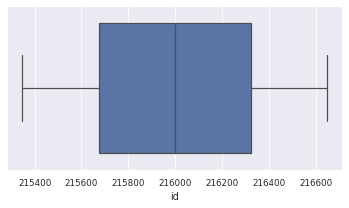

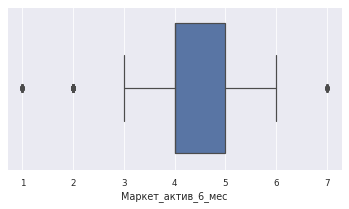

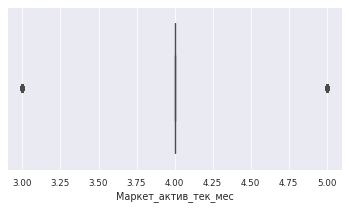

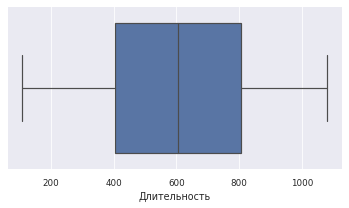

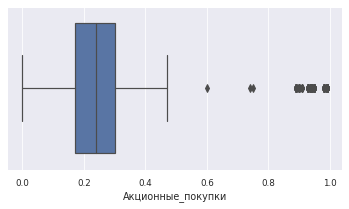

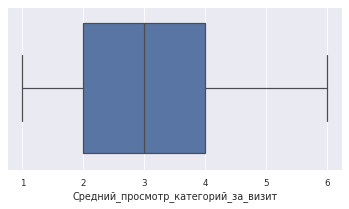

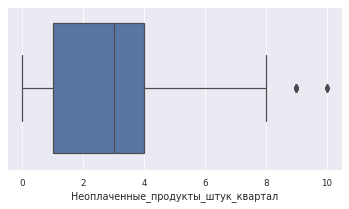

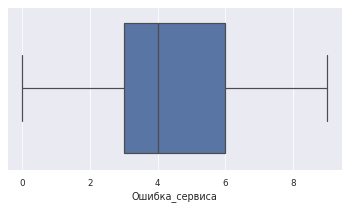

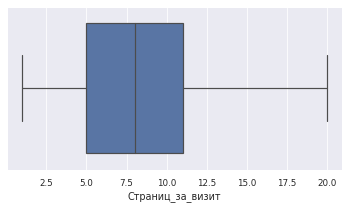

mm


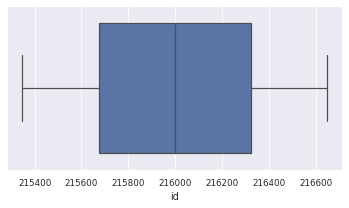

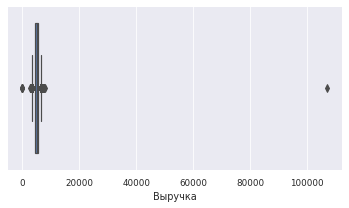

mt


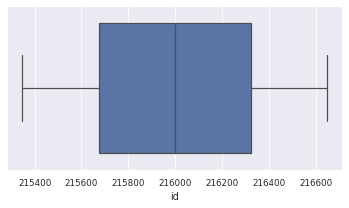

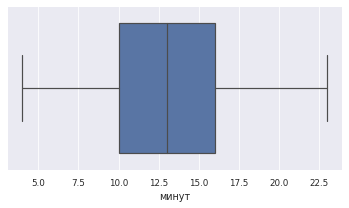

m


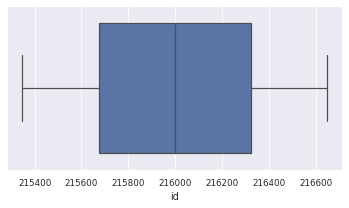

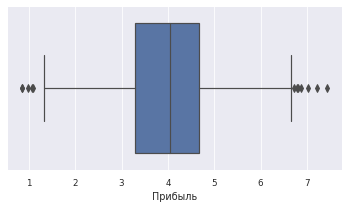

In [15]:
for name, df in data.items(): 
    print(name)
    for col in df.columns: 
        if df[col].dtype in ['int64', 'float64']:
            plt.figure(figsize=(6,3)) 
            sb.boxplot(x=df[col]) 
            plt.show() 

По графикам боксплот видны выбросы, но то что было классифицировано графиками как выбросы не обязательно на самом деле ими являются, поэтому не будем их обрабатывать. Однако, два выброса в столбце "Выручка", они сминают весь график и различаются от всех остальных значений параметра более чем в 10 раз. Это явные выбросы - заменим медианой.

### Упорядочивание названий столбцов

In [16]:
mf.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in mf.columns]
mf = mf.rename(columns = {'покупательская активность':'покупательская_активность',
                          'тип сервиса':'тип_сервиса',
                          'разрешить сообщать':'разрешить_сообщать'})
mt.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in mt.columns]
mm.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in mm.columns]
m.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in m.columns]
mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   int64  
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### Вывод

На этапе предобработки было выявлено:
- Названия столбцов оставили кириллицей согласно ТЗ, привели к змеиному виду
- Пропусков в значениях обнаружено не было
- Полных дубликатов обнаружено не было
- Неявные дубликаты были устранены
- Два явных выброса было устранено, остальные не тронуты

<a id='4-topoc'></a>
## Исследовательский анализ

mf


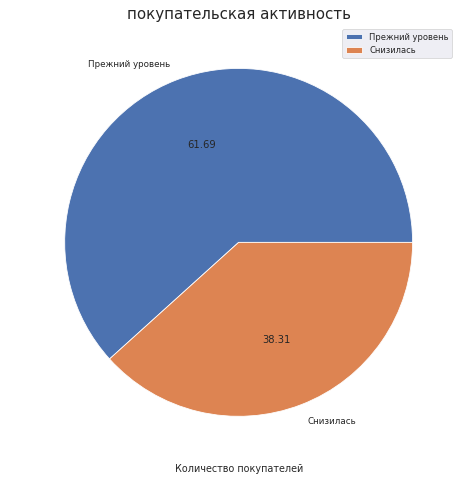

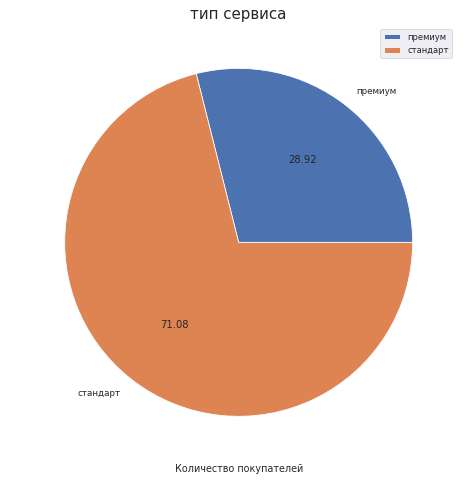

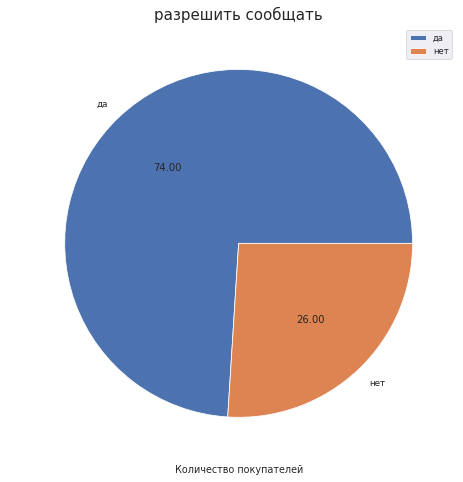

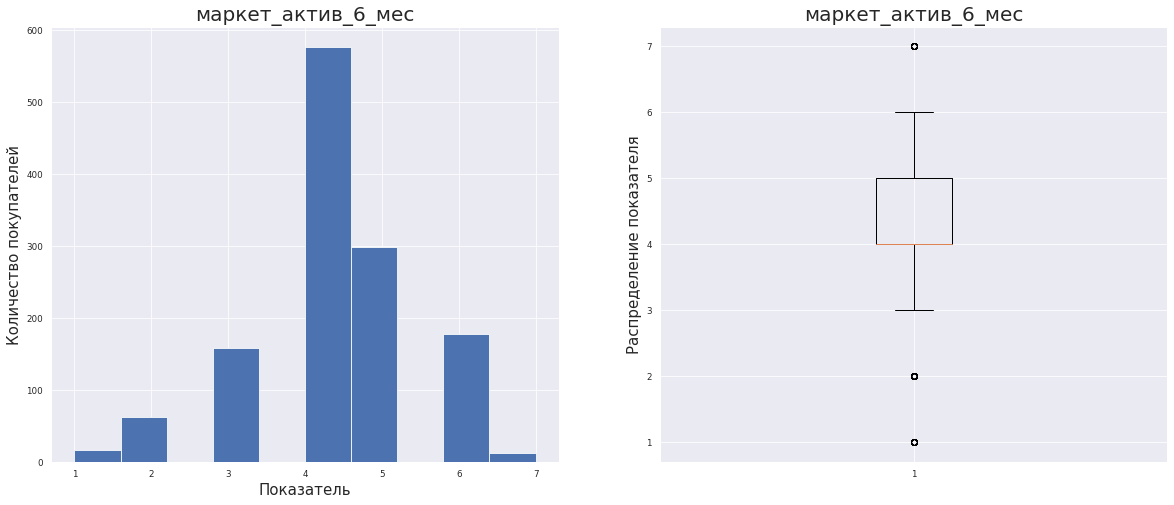

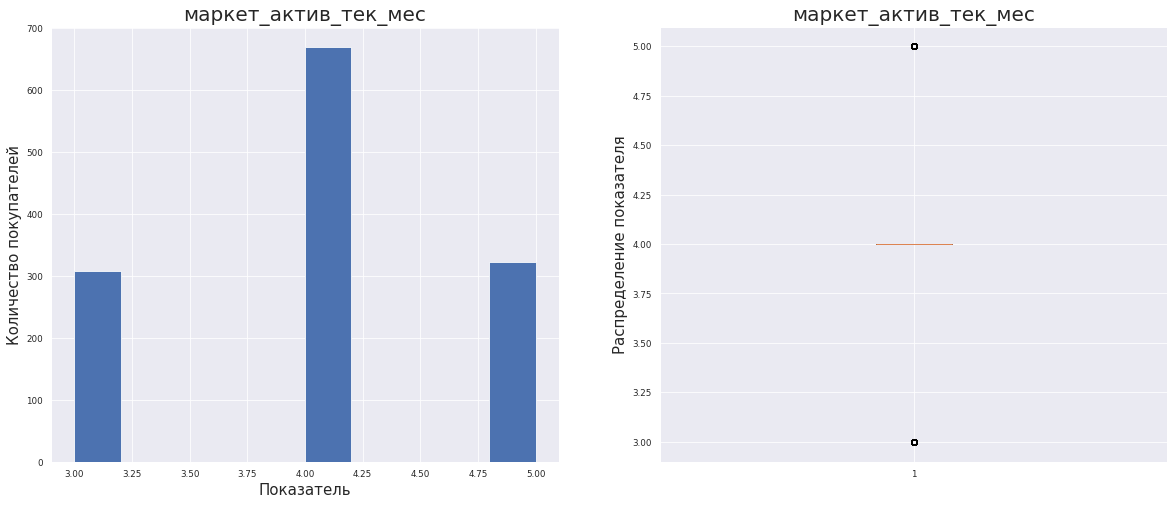

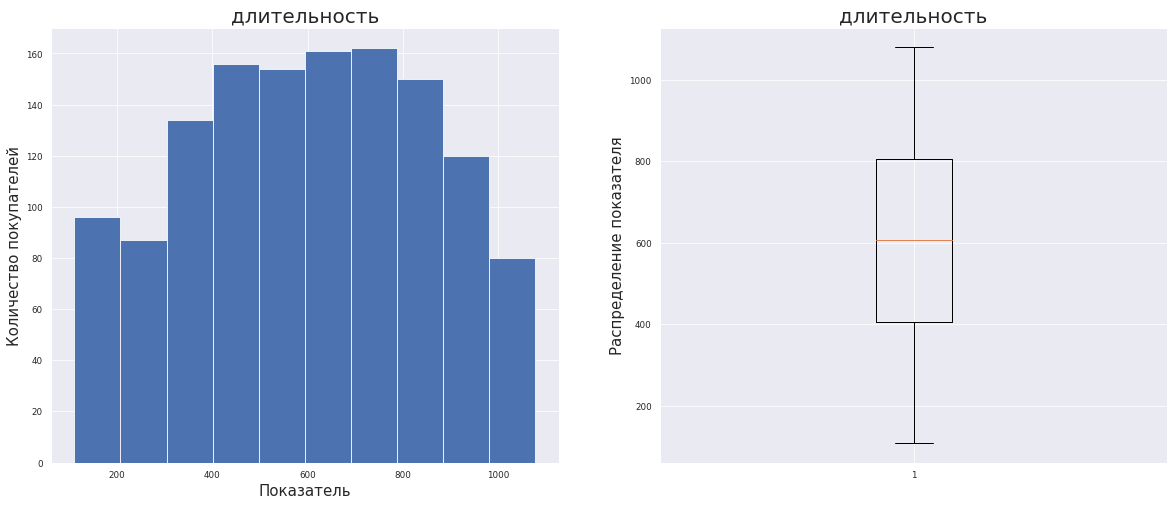

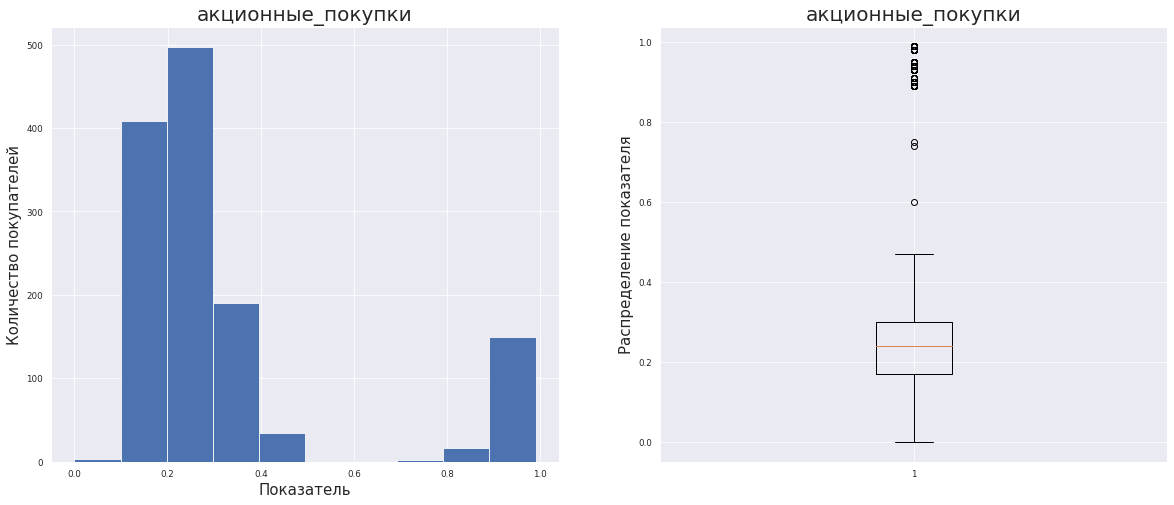

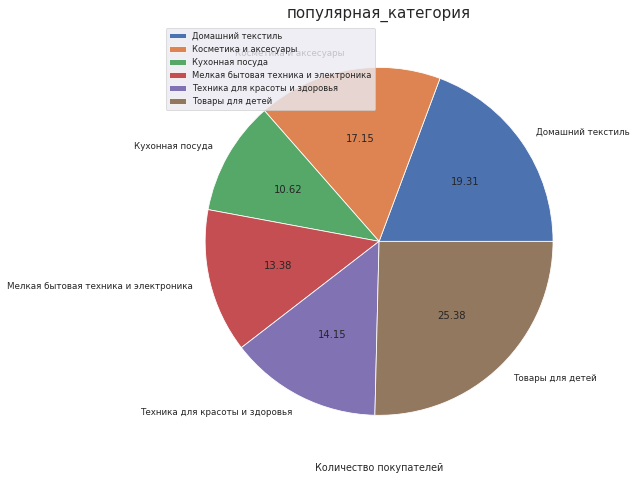

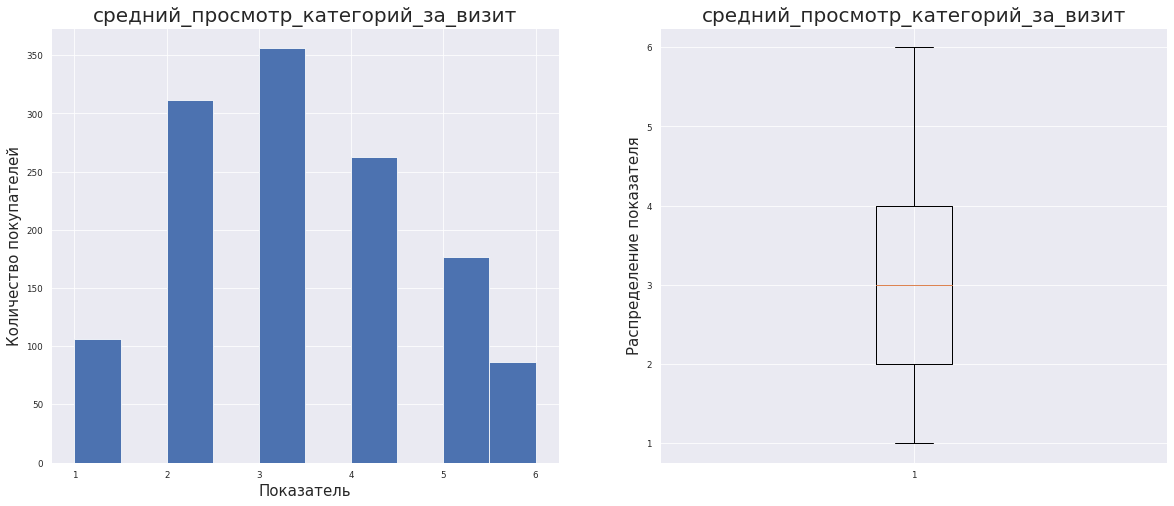

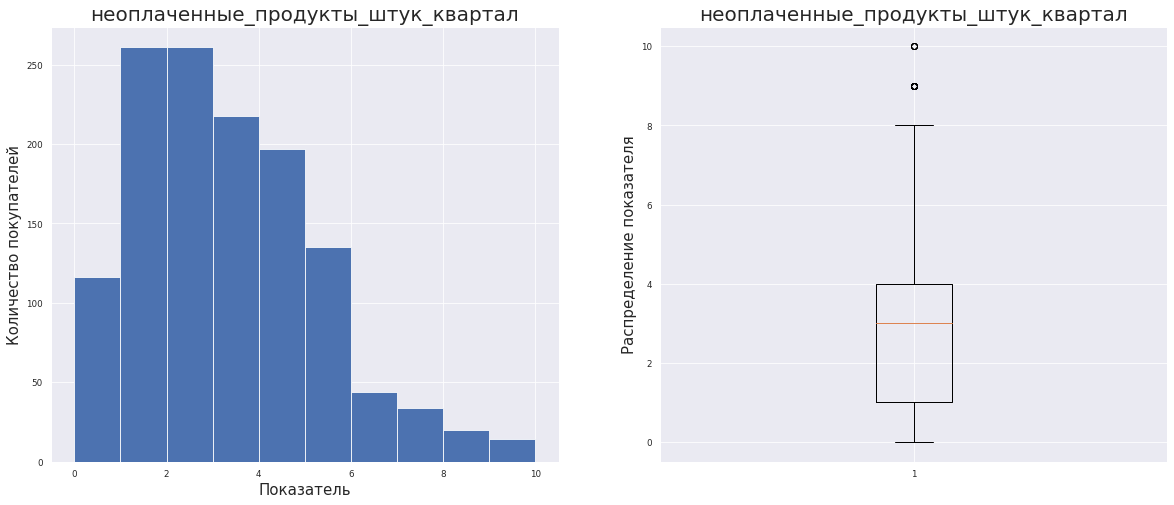

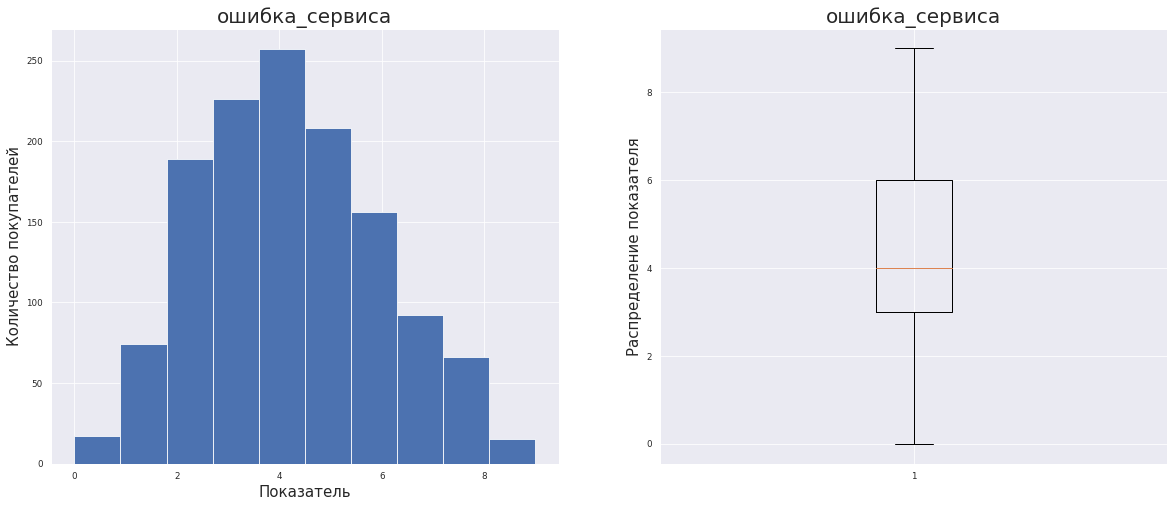

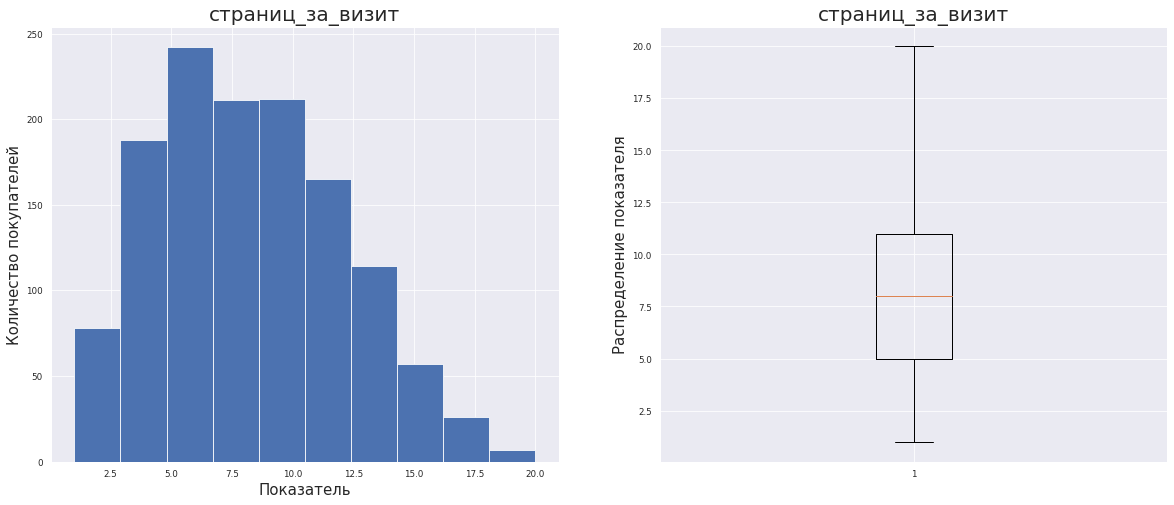

mm


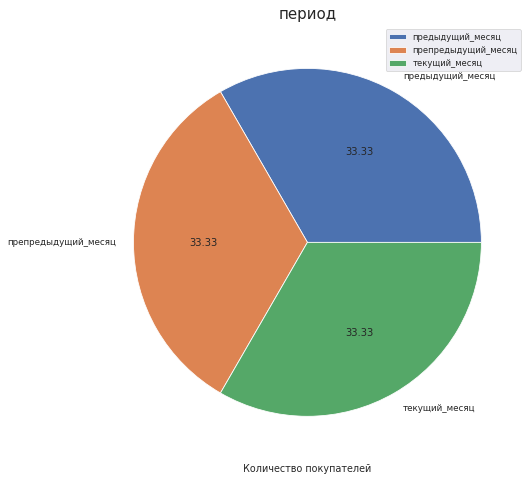

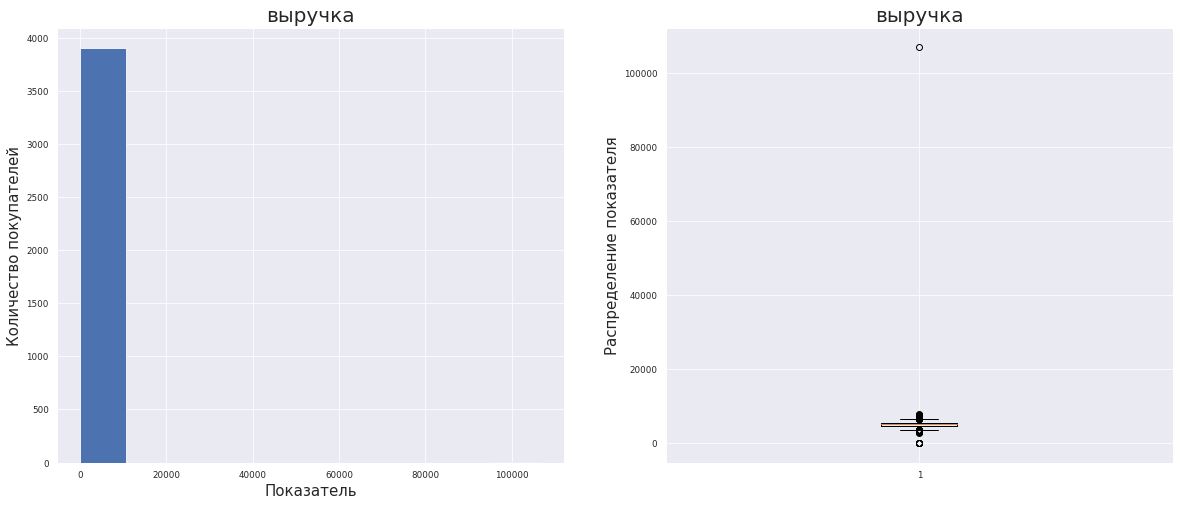

mt


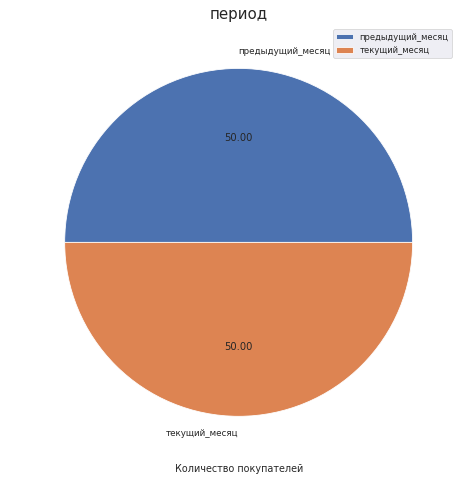

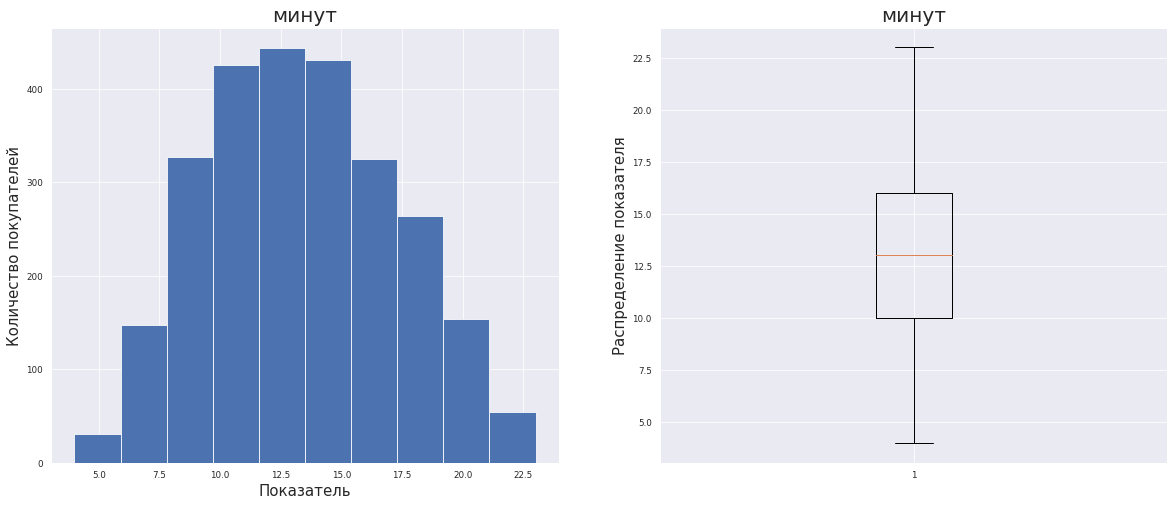

m


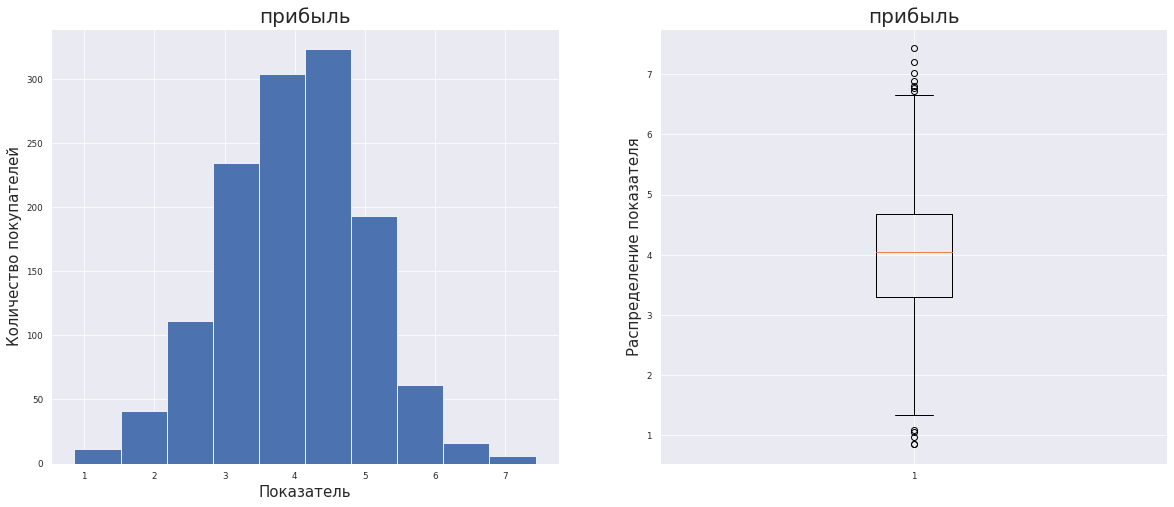

In [17]:
for name, df in data.items(): 
    print(name)
    for col in df.columns:
        if (df[col].dtype in ['int64', 'float64']) and (col != 'id'):
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
            axes[0].hist(x=df[col])
            axes[0].set_title(col, fontsize=20)
            axes[0].set_xlabel('Показатель', fontsize=15)
            axes[0].set_ylabel('Количество покупателей', fontsize=15)
            
            axes[1].boxplot(x=df[col])
            axes[1].set_title(col, fontsize=20)
            axes[1].set_xlabel(' ')
            axes[1].set_ylabel('Распределение показателя', fontsize=15)

            plt.show()
        else:
            if (col != 'id') & (col != 'Период'):
                plt.figure() 
                plotik = df.groupby(col)['id'].count().plot.pie(figsize=(15,8), autopct="%.2f",subplots=False, legend=True)
                plotik.set_xlabel('Количество покупателей')
                plotik.set_title(col, fontsize=15)
                plotik.set_ylabel(' ')

<AxesSubplot:xlabel='разрешить_сообщать', ylabel='Count'>

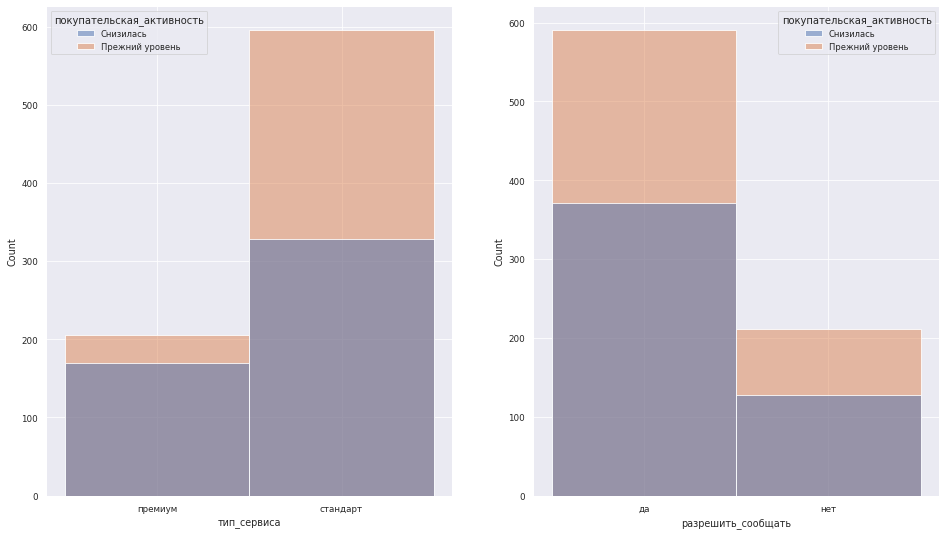

In [18]:
plt.subplot(1, 2, 1)
sb.histplot(data=mf, x='тип_сервиса', hue='покупательская_активность')
plt.subplot(1, 2, 2)
sb.histplot(data=mf, x='разрешить_сообщать', hue='покупательская_активность')

По графикам выше можно увидеть:
- покупательская активность снижается в 38% случаев
- пользователи чаще пользуются сервисом с типом стандарт
- достаточно часто разрешают рассылать дополнительные предложения
- по акционным покупкам проглядывается две группы пользователей - можно создать доп. класс
- самая популярная категория - товары для детей
- пользователи достаточно редко просматривают все категории товаров
- по времени проведенном на сайте тоже можно создать доп. класс
- по датасетам с деньгами и минутами надо построить доп. графики по периодам

В дальнейшем можно будет протестировать как модель лучше учится на доп. классах или на оригинальных данных

Выделение доп. классов

In [19]:
mf['группы_по_акц'] = 10
mf.loc[mf['акционные_покупки'] < 0.5,'группы_по_акц'] = 0
mf.loc[mf['акционные_покупки'] > 0.5,'группы_по_акц'] = 1
mf['группы_по_акц'].astype('bool')

mt['группы_минут'] = 10
mt.loc[mt['минут'] <= 10,'группы_минут'] = 1
mt.loc[(mt['минут'] > 10) & (mt['минут'] <= 15),'группы_минут'] = 2
mt.loc[mt['минут'] > 15,'группы_по_акц'] = 3

Дополнительная визуализация параметров выручки и минут по периодам

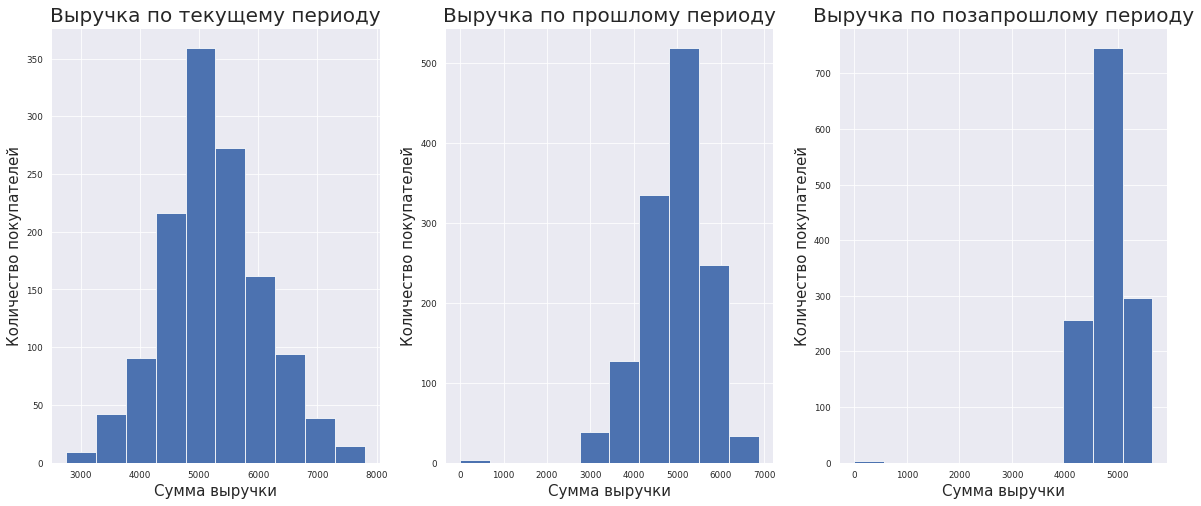

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,8))

mm_t = mm[mm['выручка'] < 100000]
this_per = mm_t[mm_t['период'] == 'текущий_месяц']
axes[0].hist(x=(this_per['выручка']))
axes[0].set_title('Выручка по текущему периоду',fontsize = 20)
axes[0].set_xlabel('Сумма выручки',fontsize = 15)
axes[0].set_ylabel('Количество покупателей',fontsize = 15)

last_per = mm[mm['период'] == 'предыдущий_месяц']
axes[1].hist(x=(last_per['выручка']))
axes[1].set_title('Выручка по прошлому периоду',fontsize = 20)
axes[1].set_xlabel('Сумма выручки',fontsize = 15)
axes[1].set_ylabel('Количество покупателей',fontsize = 15)

last_last_per = mm[mm['период'] == 'препредыдущий_месяц']
axes[2].hist(x=(last_last_per['выручка']))
axes[2].set_title('Выручка по позапрошлому периоду',fontsize = 20)
axes[2].set_xlabel('Сумма выручки',fontsize = 15)
axes[2].set_ylabel('Количество покупателей',fontsize = 15)

plt.show()

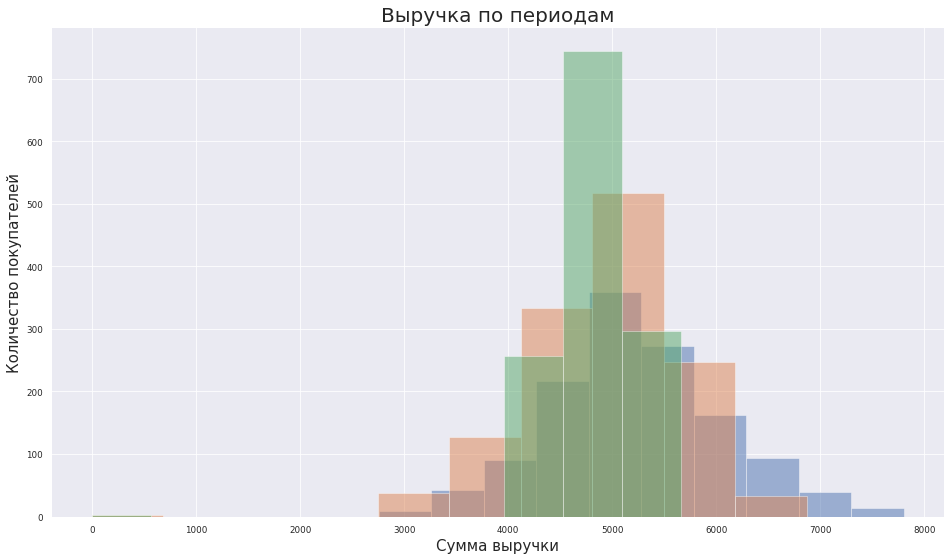

In [21]:
plt.hist(x=(this_per['выручка']),alpha=0.5)
plt.title('Выручка по периодам',fontsize = 20)
plt.xlabel('Сумма выручки',fontsize = 15)
plt.ylabel('Количество покупателей',fontsize = 15)
plt.hist(x=(last_per['выручка']),alpha=0.5)
plt.hist(x=(last_last_per['выручка']),alpha=0.5)
plt.show()

Text(0, 0.5, 'Количество покупателей')

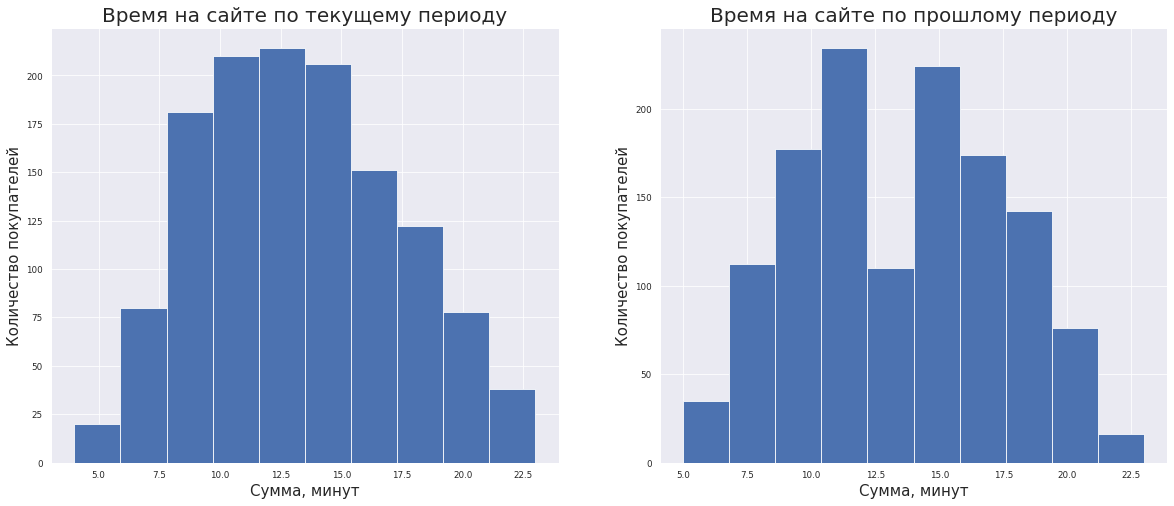

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

this_per = mt[mt['период'] == 'текущий_месяц']
axes[0].hist(x=(this_per['минут']))
axes[0].set_title('Время на сайте по текущему периоду',fontsize = 20)
axes[0].set_xlabel('Сумма, минут',fontsize = 15)
axes[0].set_ylabel('Количество покупателей',fontsize = 15)

last_per = mt[mt['период'] == 'предыдущий_месяц']
axes[1].hist(x=(last_per['минут']))
axes[1].set_title('Время на сайте по прошлому периоду',fontsize = 20)
axes[1].set_xlabel('Сумма, минут',fontsize = 15)
axes[1].set_ylabel('Количество покупателей',fontsize = 15)


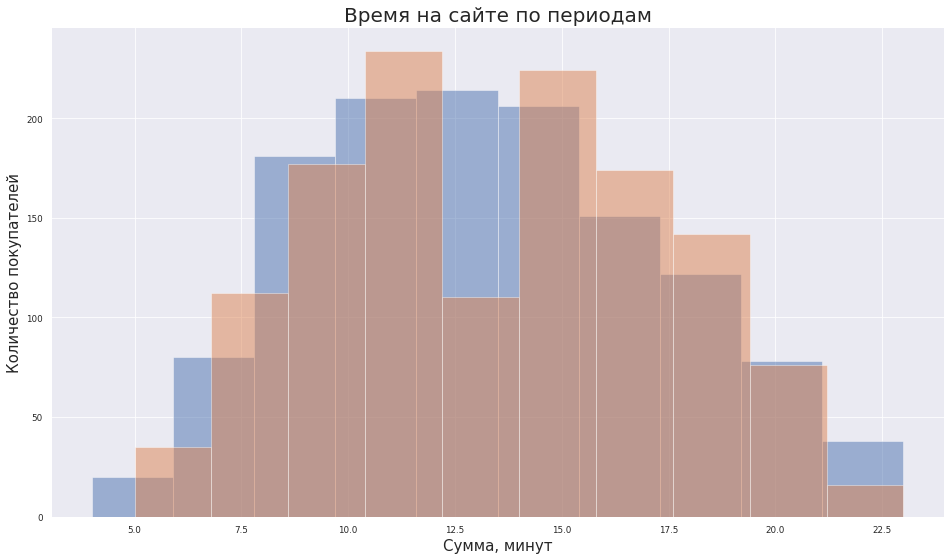

In [23]:
this_per = mt[mt['период'] == 'текущий_месяц']
plt.hist(x=(this_per['минут']),alpha = 0.5)
plt.title('Время на сайте по периодам',fontsize = 20)
plt.xlabel('Сумма, минут',fontsize = 15)
plt.ylabel('Количество покупателей',fontsize = 15)
last_per = mt[mt['период'] == 'предыдущий_месяц']
plt.hist(x=(last_per['минут']),alpha = 0.5)
plt.show()

По графикам выше можно увидеть, что в текушем периоде самая высокая выручка. Время проведенное на сайте относительно прошлого периода сократилось.

### Вывод

В результате проведенного исследовательского анализа данных можно сделать следующие выводы:
- покупательская активность снижается в 38% случаев
- пользователи чаще пользуются сервисом с типом стандарт
- достаточно часто разрешают рассылать дополнительные предложения
- по акционным покупкам проглядывается две группы пользователей - был создан доп.класс
- самая популярная категория - товары для детей
- пользователи достаточно редко просматривают все категории товаров
- по времени проведенном на сайте тоже был создан доп.класс
- по датасетам с деньгами и минутами надо построить доп. графики по периодам
- в текушем периоде самая высокая выручка
- время проведенное на сайте относительно прошлого периода сократилось

<a id='5-topoc'></a>
## Объединение таблиц

Посмотрим на размеры таблиц и столбцы с ключами по которым можно их объединить

In [24]:
for name, df in data.items():
    display(name, df.head(5), df['id'].count())

'mf'

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,5,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2


1300

'mm'

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


3900

'mt'

,id,период,минут,группы_минут,группы_по_акц
0,215348,текущий_месяц,14,2,NaN
1,215348,предыдущий_месяц,13,2,NaN
2,215349,текущий_месяц,10,1,NaN
3,215349,предыдущий_месяц,12,2,NaN
4,215350,текущий_месяц,13,2,NaN


2600

'm'

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


1300

Таблицы mf и m можно объединить по id, в остальных таблицах id дублируется. Перед объединением нужно выполнить группировку.

In [25]:
mf_m = mf.set_index('id').join(m.set_index('id'))
print('Размерность результирующего дф: ',mf_m.shape[0])

Размерность результирующего дф:  1300


In [26]:
mm_ = mm.pivot_table(index='id',columns='период',values='выручка')
mm_ = mm_.rename(columns = {
    'предыдущий_месяц':'выручка_предыдущий_месяц',
    'препредыдущий_месяц':'выручка_препредыдущий_месяц',
    'текущий_месяц':'выручка_текущий_месяц'
})
mt_ = mt.pivot_table(index='id',columns='период',values='минут',aggfunc='sum')
mt_ = mt_.rename(columns = {
    'предыдущий_месяц':'минут_предыдущий_месяц',
    'текущий_месяц':'минут_текущий_месяц'
})
display(mm_,mt_)

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


период,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [27]:
mm_.index = mm_.index.astype(mf_m.index.dtype)
mf_m_mm = mf_m.join(mm_,how ='inner')
print('Размерность результирующего дф: ',mf_m_mm.shape[0])

Размерность результирующего дф:  1300


In [28]:
mt_.index = mt_.index.astype(mf_m_mm.index.dtype)
full = mf_m_mm.join(mt_,how ='inner')
print('Размерность результирующего дф: ',mf_m_mm.shape[0])

Размерность результирующего дф:  1300


### Вывод

Все датасеты были объеденены, в процессе объединения столбец с доп.группами по минутам пришлось упразднить. Если результаты работы модели будут слабыми можно будет вернуться к доп. классам.

In [29]:
full = full[(full['выручка_предыдущий_месяц']!=0)&
            (full['выручка_препредыдущий_месяц']!=0)&
            (full['выручка_текущий_месяц']!=0)&
            (full['выручка_текущий_месяц']<100000)
           ]
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   int64  
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

<a id='6-topoc'></a>
## Корреляционный анализ

Построим диаграмму хотплот корреляции параметров с коэфициентом Спирмена так как у нас не все количественные признаки имеют нормальное распределение.

Text(0.5, 59.7, 'Параметры')

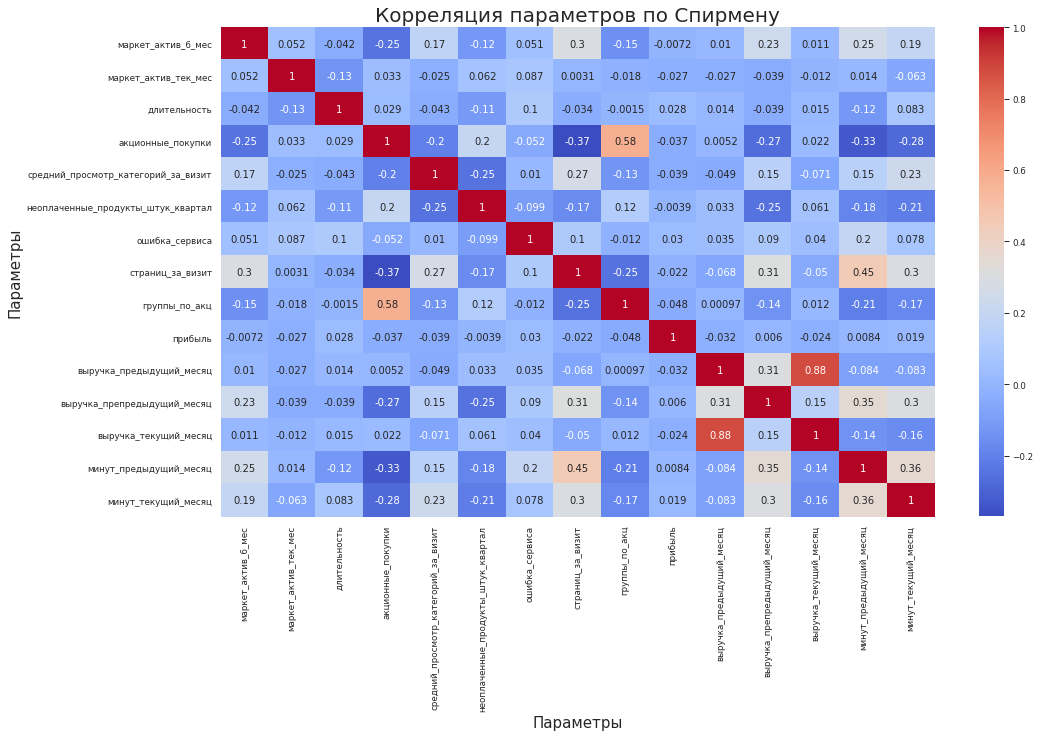

In [30]:
full_sp = sb.heatmap(full.corr(method = 'spearman'), annot=True, cmap='coolwarm')
full_sp.set_title('Корреляция параметров по Спирмену', fontsize=20)
full_sp.set_ylabel('Параметры', fontsize=15)
full_sp.set_xlabel('Параметры', fontsize=15)

Чтобы посмотреть корреляцию вводных с целевым, построим еще одну диаграмму с категориальными величинами

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'группы_по_акц', 'прибыль', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


Text(0.5, 59.7, 'Параметры')

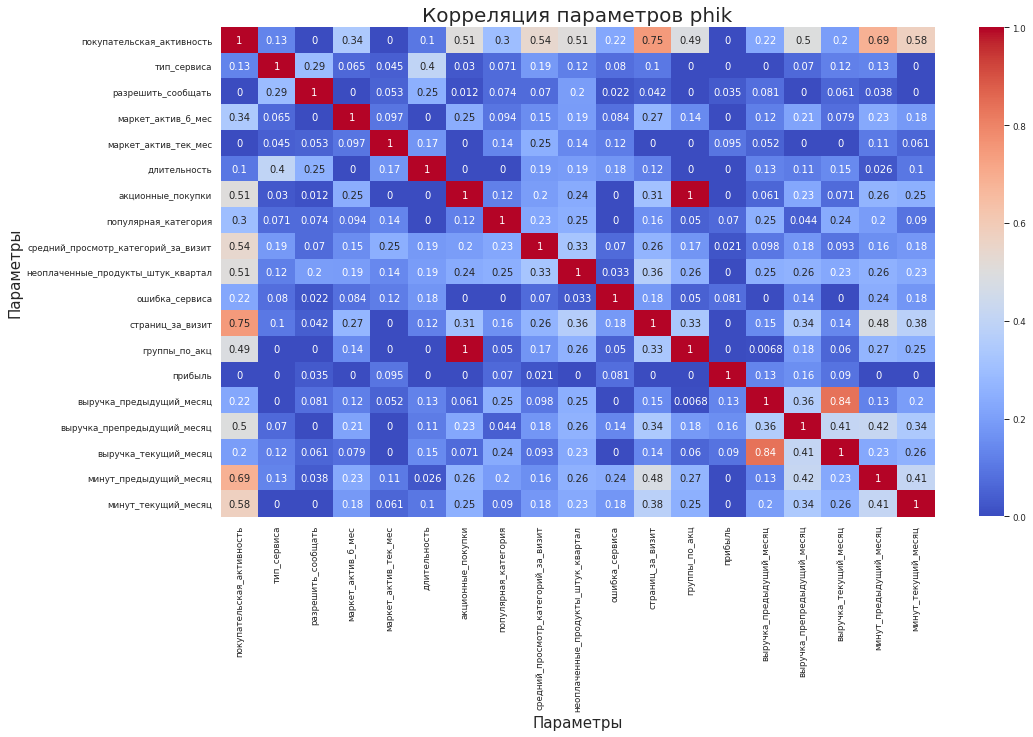

In [31]:
full_phik = sb.heatmap(full.phik_matrix(), annot=True, cmap='coolwarm')
full_phik.set_title('Корреляция параметров phik', fontsize=20)
full_phik.set_ylabel('Параметры', fontsize=15)
full_phik.set_xlabel('Параметры', fontsize=15)

Чтобы подробней изучить корреляцию параметров для пользователей, чья активность снизилась и тех, чья активность не изменилась - построим отдельные диаграммы корреляций

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'группы_по_акц', 'прибыль', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'группы_по_акц', 'прибыль', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


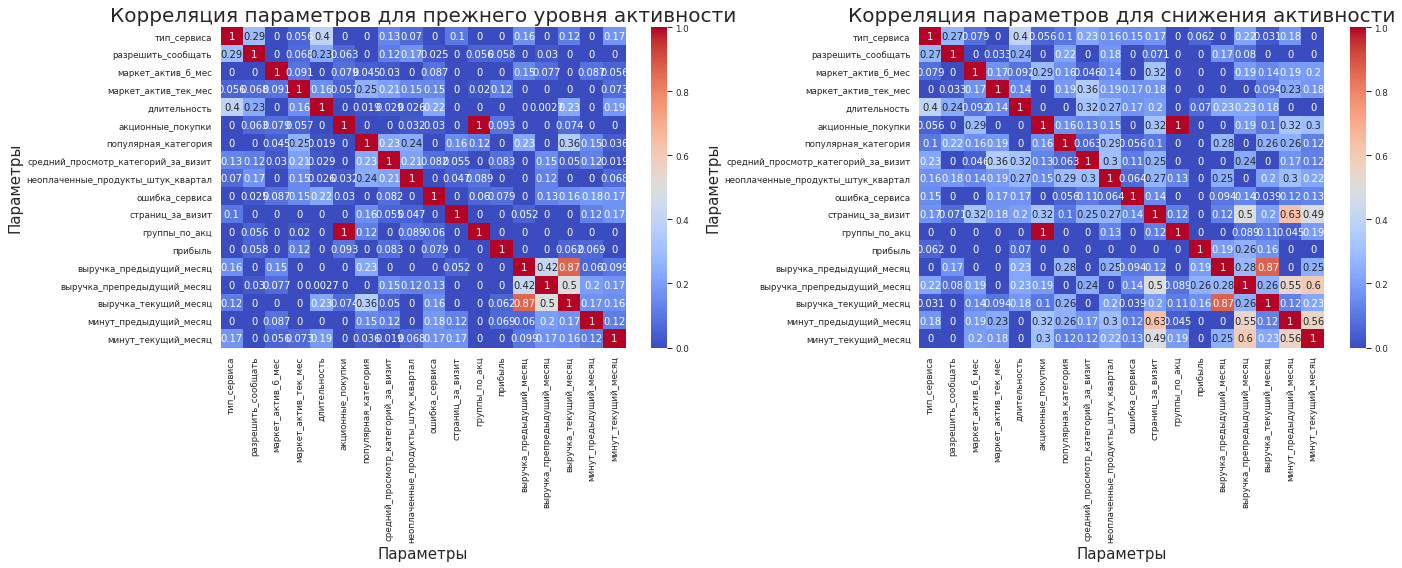

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

full_phik_still_so = full[full['покупательская_активность'] == 'Прежний уровень']
sb.heatmap(full_phik_still_so.phik_matrix(), annot=True, cmap='coolwarm', ax=axes[0])  
axes[0].set_title('Корреляция параметров для прежнего уровня активности', fontsize=20)
axes[0].set_ylabel('Параметры', fontsize=15)
axes[0].set_xlabel('Параметры', fontsize=15)

full_phik_less = full[full['покупательская_активность'] == 'Снизилась']
sb.heatmap(full_phik_less.phik_matrix(), annot=True, cmap='coolwarm', ax=axes[1]) 
axes[1].set_title('Корреляция параметров для снижения активности', fontsize=20)
axes[1].set_ylabel('Параметры', fontsize=15)
axes[1].set_xlabel('Параметры', fontsize=15)

plt.tight_layout() 
plt.show()

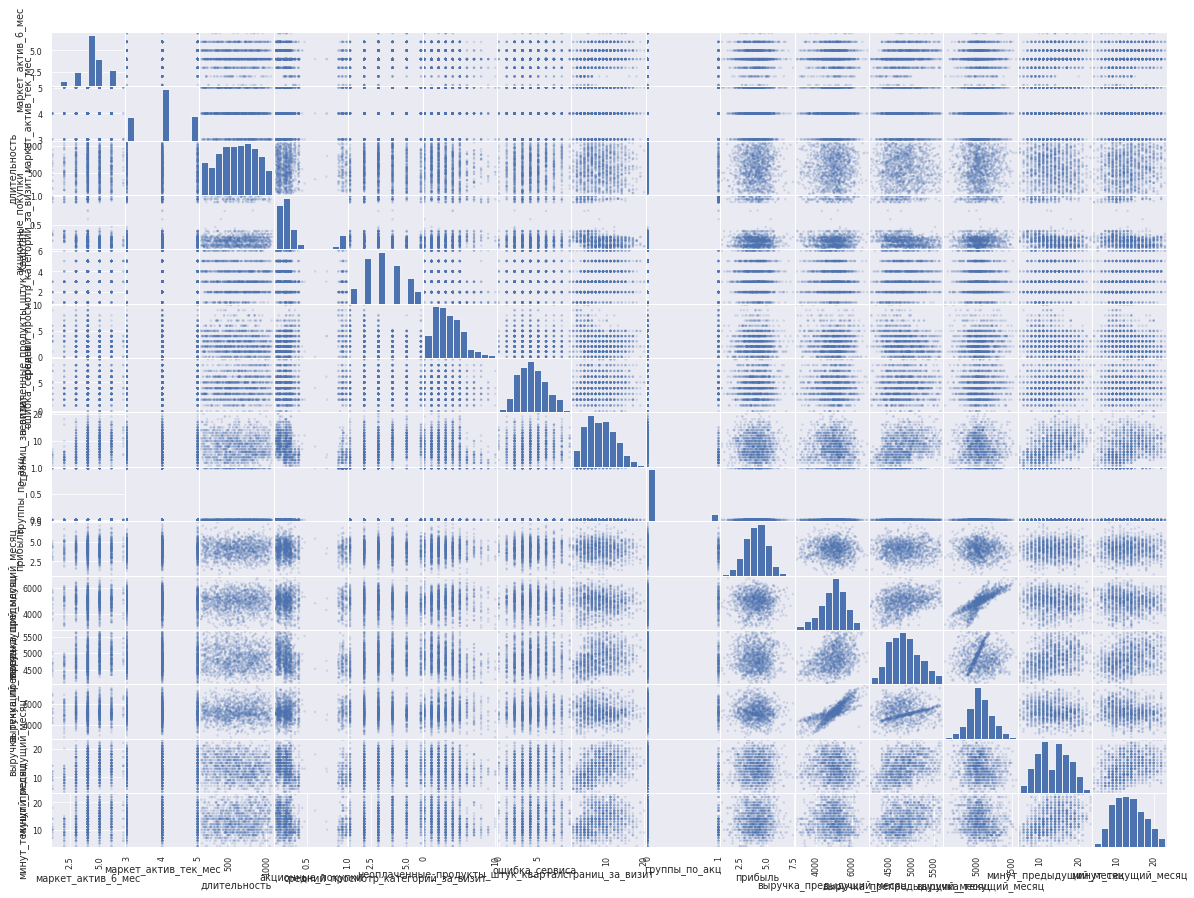

In [33]:
full_sm = full
full_sm = pd.plotting.scatter_matrix(full_sm, alpha=0.2,ax=None, figsize = (20,15))

### Вывод

По проведенному корреляционному анализу данных можно сделать следующие выводы:
- Доп. параметр "Группы по акциям" имеет очень выраженную связь с параметром "Акционные покупки" - это логично, при построении будем брать эти параметры отдельно
- У целевого показателя "Покупательская активность" есть выраженная линейная связь с параметрами "Акционные покупки", "Неоплаченные покупки" 
- У показателей выручки за текущий и предыдущий периоды также есть выраженная линейная связь
- Мультиколинеарности вводных не обнаружено
- При анализе корреляции снижения активности мы видим увеличение коэффициента корреляции для параметров: выручки и минут проведенных на сайте, минут и просмотренных страниц

<a id='7-topoc'></a>
## Использование пайплайнов

In [34]:
label_mapping = {'Снизилась': 1, 'Прежний уровень': 0}
label_encoder = LabelEncoder()
full['покупательская_активность'] = label_encoder.fit_transform(full['покупательская_активность'].map(label_mapping)) 
full['покупательская_активность']

id
215349    1
215350    1
215351    1
215352    1
215353    1
         ..
216643    0
216644    0
216645    0
216646    0
216647    0
Name: покупательская_активность, Length: 1296, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    full.drop(['покупательская_активность','группы_по_акц'], axis=1),
    full['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = full['покупательская_активность'])

X_train.shape, X_test.shape

((972, 17), (324, 17))

In [36]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']

ord_columns = ['тип_сервиса']

num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'прибыль', 
               'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц',
               'выручка_текущий_месяц',
              ]

ord_categories = [['премиум', 'стандарт']]

In [37]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first',sparse_output=False))
    ])

ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(
                categories=ord_categories, 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan))])


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models2', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_2 = [    
    
    # словарь для модели LogisticRegression()
    
    
    {
        'models2': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear',
            penalty='l1',
            class_weight='balanced',
            warm_start=True)],
        'models2__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    }]

param_grid = [
    

    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2,5),
        'preprocessor__num': [ MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },
     

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear',
            penalty='l1',
            class_weight='balanced',
            warm_start=True
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },


    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    }

]

In [38]:
randomized_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели по кросс валидацинной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}') 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                                               'стандарт']],
                                               

In [39]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-score': f1_score(y_test, y_test_pred)
}

print("Метрики модели:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}") 

Метрики модели:
Accuracy: 0.9167
Precision: 0.9800
Recall: 0.7967
F1-score: 0.8789


### Вывод

Оценку лучшей модели при кросс валидационном цикле выбрали roc_auc так как она отлично подходит для задач бинарной классификации с несбалансированной выборкой

Лучшая модель:  Метод опорных векторов

Метрика лучшей модели по кросс валидацинной выборке: 0.9054403439575909

Метрика ROC-AUC на тестовой выборке: 0.882121649815439

Для оценки качества модели также были построены метрики: Accuracy, Precision, Recall, F1-score и roc_auc_score. В данной задаче нас больше всего интересует метрика Recall так как она измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса (когда снижение активности ложно классифицируется как прежняя активность). У нашей модели Recall = 77%.

<a id='8-topoc'></a>
## Анализ важности признаков

7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
7.2 Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [40]:
perm_importance = permutation_importance(
    randomized_search.best_estimator_, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=RANDOM_STATE
)

feature_importances = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean
    })

# Сортировка таблицы по важности
print(feature_importances.sort_values('Importance', ascending=False))


                                Feature  Importance
10                     страниц_за_визит    0.108025
15               минут_предыдущий_месяц    0.064506
16                  минут_текущий_месяц    0.046296
5                     акционные_покупки    0.016667
8    неоплаченные_продукты_штук_квартал    0.012346
7   средний_просмотр_категорий_за_визит    0.005864
13          выручка_препредыдущий_месяц    0.002469
2                    маркет_актив_6_мес    0.002160
9                        ошибка_сервиса    0.002160
4                          длительность    0.000000
6                  популярная_категория    0.000000
1                    разрешить_сообщать    0.000000
3                  маркет_актив_тек_мес    0.000000
11                              прибыль    0.000000
12             выручка_предыдущий_месяц    0.000000
14                выручка_текущий_месяц    0.000000
0                           тип_сервиса    0.000000


In [41]:
randomized_search_new = GridSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

randomized_search_new.fit(X_train, y_train)


print('Лучшая модель логистической регрессии и её параметры:\n\n', randomized_search_new.best_estimator_)
print ('Метрика лучшей модели по кросс валидацинной выборке:', randomized_search_new.best_score_)

y_test_pred = randomized_search_new.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}') 

Лучшая модель логистической регрессии и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                                               'стандарт']],
                       

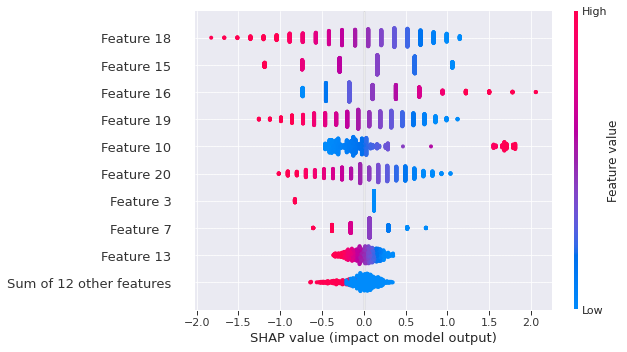

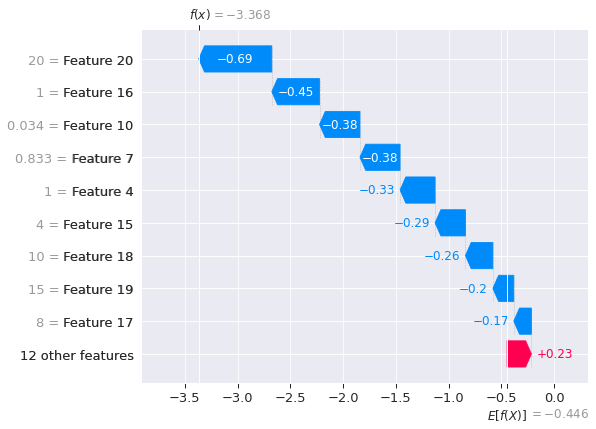

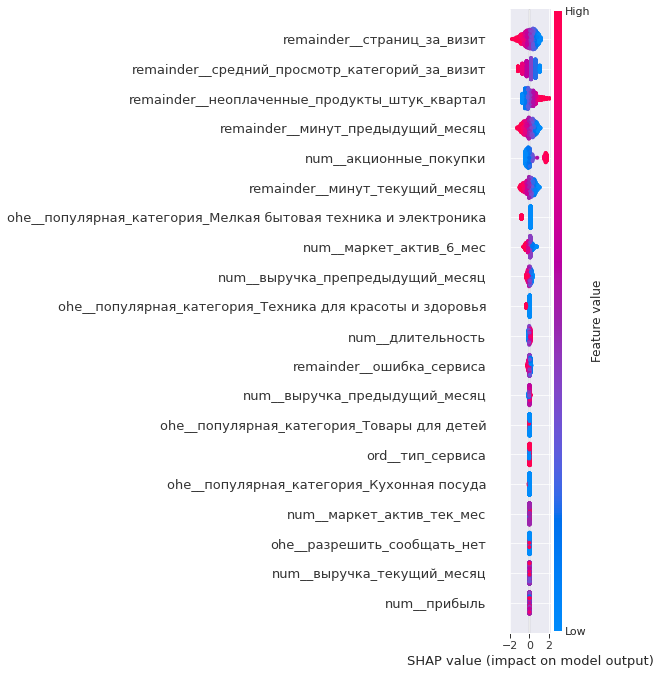

In [42]:
model = randomized_search_new.best_estimator_.named_steps['models2'] 

X_train_transformed = randomized_search_new.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
feature_names = randomized_search_new.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 

# Используем X_train_transformed в shap.LinearExplainer
explainer = shap.LinearExplainer(model, X_train_transformed)  # или shap.KernelExplainer
shap_values = explainer(X_train_transformed)

# Построение графиков
shap.plots.beeswarm(shap_values)
plt.show()

shap.plots.waterfall(shap_values[5])
plt.show() 

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
plt.show()



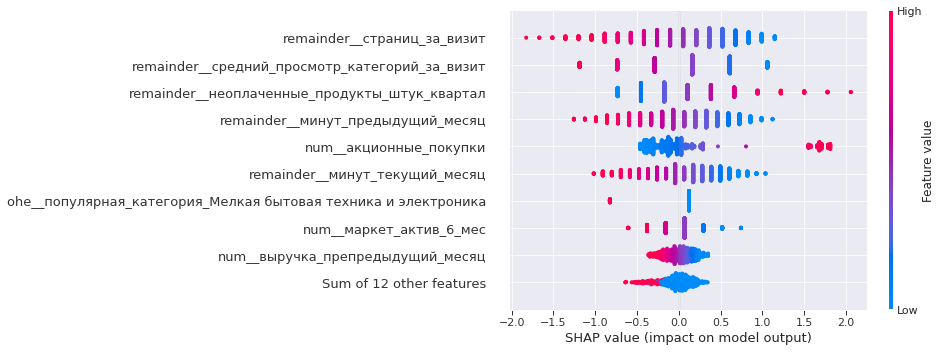

In [51]:
# код ревьюера
model = randomized_search_new.best_estimator_.named_steps['models2'] 

X_train_transformed = randomized_search_new.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
feature_names = randomized_search_new.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 

# Используем X_train_transformed в shap.LinearExplainer
explainer = shap.LinearExplainer(model, X_train_transformed, feature_names=feature_names)  # или shap.KernelExplainer
shap_values = explainer(X_train_transformed)

# Построение графиков
shap.plots.beeswarm(shap_values)
plt.show()


### Вывод

По таблице оценки важности признаков можно увидеть, что модель оценила признак количества страниц за визит и время нахождения на сайте за период как наиболее важные. Мало значимыми для модели оказались количество маркетинговых коммуникаций в текущем месяце, ошибки сервиса и самая популярная категория товаров у покупателя за последние 6 месяцев. По анализу графиков важности самыми весомымы оказались те же признаки что и по таблице оценок.

<a id='9-topoc'></a>
## Сегментация покупателей

### Сегментация по итогам моделирования

Text(0, 0.5, 'Количество посещаемых страниц')

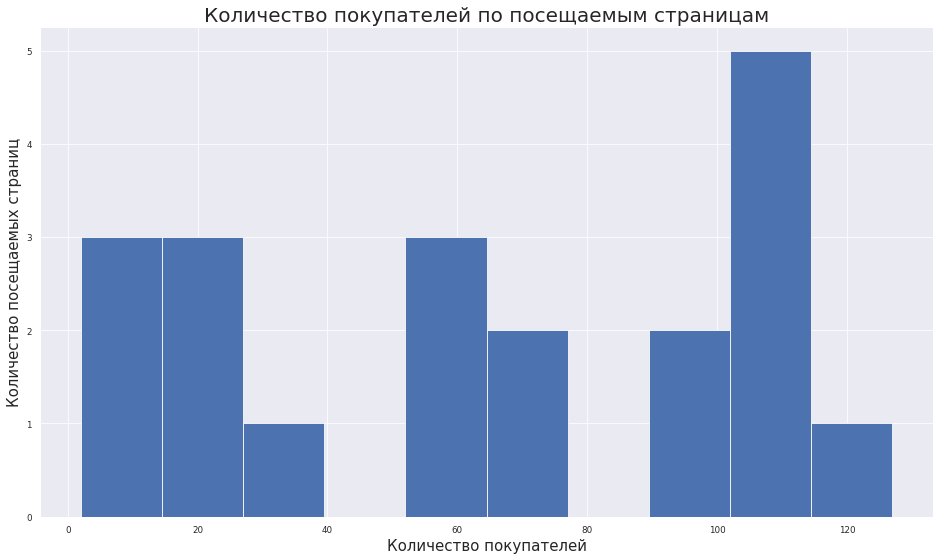

In [43]:
segment_hist = full.groupby('страниц_за_визит')['разрешить_сообщать'].count().hist(bins=10)
segment_hist.set_title('Количество покупателей по посещаемым страницам',fontsize=20)
segment_hist.set_xlabel('Количество покупателей',fontsize=15)
segment_hist.set_ylabel('Количество посещаемых страниц',fontsize=15)

По посещаемым страницам четко проглядываются сегменты с малой, средней и высокой посещаемостью

Text(0, 0.5, 'Количество посещаемых страниц')

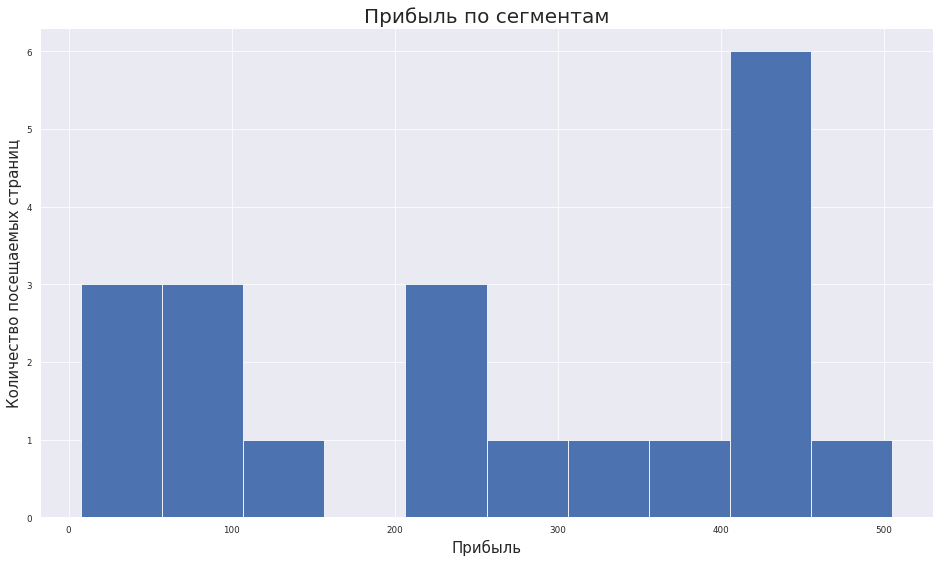

In [44]:
segment_hist = full.groupby('страниц_за_визит')['прибыль'].sum().hist(bins=10)
segment_hist.set_title('Прибыль по сегментам',fontsize=20)
segment_hist.set_xlabel('Прибыль',fontsize=15)
segment_hist.set_ylabel('Количество посещаемых страниц',fontsize=15)

Если проанализировать прибыльность по посещаемости, то также проглядываются сегменты пользователей.

### Планы по увеличению покупательской активности

Ранее удалось выявить сегмент покупателей, которые просматривают мало страниц сайта, так как это один из ключевых показателей который влияет на снижение покупательской активности изучим сегмент подробней.

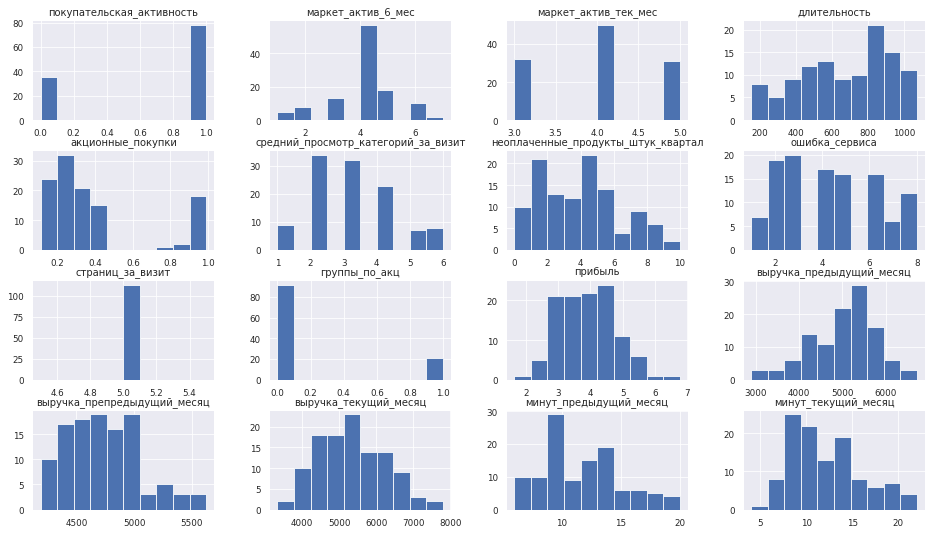

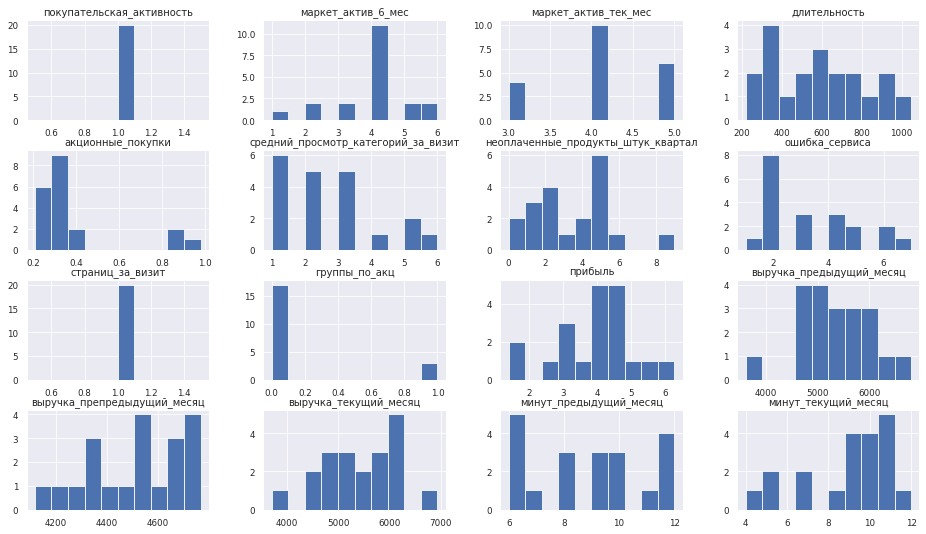

In [45]:
less_seg = full.query('страниц_за_визит < 2')
more_seg = full.query('страниц_за_визит == 5')

more_seg_hist = more_seg.hist()
less_seg_hist= less_seg.hist()

plt.show()

In [46]:
print(less_seg.groupby('популярная_категория')['страниц_за_визит'].count().sort_values(),'\n\n')
print(more_seg.groupby('популярная_категория')['страниц_за_визит'].count().sort_values())

print(less_seg.groupby('тип_сервиса')['страниц_за_визит'].count().sort_values(),'\n\n')
print(more_seg.groupby('тип_сервиса')['страниц_за_визит'].count().sort_values())

популярная_категория
Кухонная посуда                         1
Мелкая бытовая техника и электроника    1
Техника для красоты и здоровья          1
Домашний текстиль                       4
Косметика и аксесуары                   4
Товары для детей                        9
Name: страниц_за_визит, dtype: int64 


популярная_категория
Техника для красоты и здоровья          12
Кухонная посуда                         13
Мелкая бытовая техника и электроника    14
Домашний текстиль                       16
Косметика и аксесуары                   28
Товары для детей                        30
Name: страниц_за_визит, dtype: int64
тип_сервиса
премиум      4
стандарт    16
Name: страниц_за_визит, dtype: int64 


тип_сервиса
премиум     39
стандарт    74
Name: страниц_за_визит, dtype: int64


По анализу графиков выше легко видеть что этот сегмент достаточно редко пользуется акциями ( группы по акциям и акционные покупки), также очевидно что за последние три месяца они все больше и больше тратили на платформе ( что как мы видили из анализа графиков SHAP отрицательно влияет на активность) возможно покупатели оценили объем своих затрат и решили сбавить темпы в будующем, между тем количество минут проводимых на сайте несколько возросло. Значит пользователь просматривает меньше страниц, но делает это внимательней. Для превлечения покупательской активности и поддержания уровня заинтересованности рекомендуется уделить больше времени на привлекательность сайта и акционные товары, пользователей которые хотят начать экономить такие акции наверняка привлекут.

### Вывод о сегментах

1. Для дополнительного исследования был выбран сегмент покупателей которые просматривают мало страниц сайта так как именно этот показатель по мнению лучшей модели имеет самый большой "вес"(влияние на таргет). Также ранее на этапе корреляционного анализа мы выяснили, что этот показатель сильно коррелирует с таргетом. По анализу SHAP показателей мы также увидили что количество просмотренных страниц за визит делает существенный вклад в категоризацию пользователей.

2. Анализ прибыли по просмотренным страницам показал, что больше всего прибыли магазин получает от клиентов которые просматривают 6 страниц. 

3. В результате моделирования мы получили показатели, которые больше всего влияют на уход клиентов:  Количество страниц за визит (11%), минут проведенных на сайте в предыдущий месяц (7%), минут проведенных на сайте в текуший месяц (4%).

4. По результатам работы модели и доп исследованию можно выделить два сегмента. 

Прибыльные - это покупатели:
- которые просматривают 5 страниц за визит
- зарегистрировались на сервисе около 2-х лет назад
- приносят по 5-5,5 тыс. выручки ежемесячно
- проводят на сервисе около 10 минут

Не прибыльные - это покупатели:
- которые просматривают 1 страницу за визит
- зарегистрировались на сервисе около года назад
- приносят не стабильную выручку
- проводят на сервисе не стабильное количество времени

5. Так как у не прибыльных покупателей самый популярный тип товара - Товары для детей, можно предложить этим клиентам скидку в размене 15% на этоти товары. Также эти пользователи редко покупают подписку на сервис, если дать хорошую скидку на подписку (40-50%) и пользователь подписку приобретет, то время которое он проводит на сайте увеличится. 

<a id='10-topoc'></a>
## Общий вывод

Для проведения исследования предоставлены четыре датасета.

**1) В ходе превичного изучения данных было сделано:**

- Названия столбцов оставили кириллицей согласно ТЗ
- Пропусков в значениях обнаружено не было
- Полных дубликатов обнаружено не было
- Неявные дубликаты были устранены
- Два явных выброса было устранено, остальные не тронуты


---

**2) В результате проведенного исследовательского анализа данных можно сделать следующие выводы:**


- покупательская активность снижается в 38% случаев
- пользователи чаще пользуются сервисом с типом стандарт
- достаточно часто разрешают рассылать дополнительные предложения
- по акционным покупкам проглядывается две группы пользователей - был создан доп.класс
- самая популярная категория - товары для детей
- пользователи достаточно редко просматривают все категории товаров
- по времени проведенном на сайте тоже был создан доп.класс
- по датасетам с деньгами и минутами надо построить доп. графики по периодам
- в текушем периоде самая высокая выручка
- время проведенное на сайте относительно прошлого периода сократилось


---

**3) В ходе объединения:**


Все датасеты были объеденены, в процессе объединения столбец с доп.группами по минутам пришлось упразднить. Если результаты работы модели будут слабыми можно будет вернуться к доп. классам.

---


**4) По проведенному корреляционному анализу получили следующие выводы:**


- Доп. параметр "Группы по акциям" имеет очень выраженную связь с параметром "Акционные покупки" - это логично, при построении будем брать эти параметры отдельно
- У целевого показателя "Покупательская активность" есть выраженная линейная связь с параметрами "Акционные покупки", "Неоплаченные покупки" 
- У показателей выручки за текущий и предыдущий периоды также есть выраженная линейная связь
- Мультиколинеарности вводных не обнаружено

---

**5) При использовании пайплайнов достигли следующих результатов:**

Лучшая модель и её параметры:  KNeighborsClassifier(n_neighbors=3)

Метрика лучшей модели на тренировочной выборке: 0.8845838212853544

Метрика ROC-AUC на тестовой выборке: 0.903426416305569

---

**6) По анализу важности признаков можно заключить:**

По таблице оценки важности признаков можно увидеть, что модель оценила признак количества страниц за визит и время нахождения на сайте за период как наиболее важные. Мало значимыми для модели оказались количество маркетинговых коммуникаций в текущем месяце, ошибки сервиса и самая популярная категория товаров у покупателя за последние 6 месяцев. По анализу графиков важности самыми весомымы оказались те же признаки что и по таблице оценок.

---

**7) В результате сегментации выявили следующее:**

1. Для дополнительного исследования был выбран сегмент покупателей которые просматривают мало страниц сайта так как именно этот показатель по мнению лучшей модели имеет самый большой "вес"(влияние на таргет). Также ранее на этапе корреляционного анализа мы выяснили, что этот показатель сильно коррелирует с таргетом. По анализу SHAP показателей мы также увидили что покупательская активность снижается при высоких показателях выручки за прошлые периоды и повышается при увеличении маркетингового взаимодействия.

2. Анализ прибыли по просмотренным страницам показал, что больше всего прибыли магазин получает от клиентов которые просматривают 6 страниц. 

3. В результате моделирования мы получили показатели, которые больше всего влияют на уход клиентов:  Количество страниц за визит (11%), минут проведенных на сайте в предыдущий месяц (7%), минут проведенных на сайте в текуший месяц (4%).

4. По результатам работы модели и доп исследованию можно выделить два сегмента. 

Прибыльные - это покупатели:
- которые просматривают 5 страниц за визит
- зарегистрировались на сервисе около 2-х лет назад
- приносят по 5-5,5 тыс. выручки ежемесячно
- проводят на сервисе около 10 минут

Не прибыльные - это покупатели:
- которые просматривают 1 страницу за визит
- зарегистрировались на сервисе около года назад
- приносят не стабильную выручку
- проводят на сервисе не стабильное количество времени

5. Так как у не прибыльных покупателей самый популярный тип товара - Товары для детей, можно предложить этим клиентам скидку в размене 15% на этоти товары. Также эти пользователи редко покупают подписку на сервис, если дать хорошую скидку на подписку (40-50%) и пользователь подписку приобретет, то время которое он проводит на сайте увеличится. Также мы увеличиваем количество маркетинговых взаимодействий, что как мы выяснили по анализу SHAP показателей очень хорошо влияет на активность пользователей.